# Séance 2 (Rappel) : Apprentissage non supervisé

Le corpus est le même que celui de la première séance. Cette fois, nous allons nous intéresser au contenu des articles par le biais de leur résumé.

L'objectif est d'étudier des algorithmes de clustering, de comparer quantitativement leur efficacité et les résultats obtenus.

## Pré-traitement des données

Les algorithmes de clustering sont souvent gourmands en temps de calcul. Pour cette séance, il est conseillé de se contenter d'une toute petite partie du corpus, par exemple que les articles publiés en 2010 et qui sont dans le domaine de l'informatique (cf fonction sample_corpus). 

Lorsqu'on travaille avec des données textuelles, la première étape est le pré-traitement des données : lemmatizer, stop words, transformation tf-idf, ... (cf cours RITAL de M1). Les traitements minimales vous sont donnés dans les blocs suivants.


In [1]:
import json
from datetime import datetime
import re, string
import sklearn
import numpy as np
from scipy.sparse import csr_matrix,lil_matrix
import gzip

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [158]:
FILENAME = "arxiv-2010-2017.json.gz"

def read_arxiv(f=FILENAME):
    """ lit le fichier arxiv.json """
    res = dict()
    with  open(f) as fp:
        for l in fp:
            js = json.loads(l)
            res[js["id"]] = js
    return res

def build_labels(dic,labels2id=None,id2labels=None,pref=None):
    """ construit la matrice des labels associée à dic
        renvoie la matrice, le dictionnaire de correspondance entre label et index, et le dictionnaire inverse
        ne conserve que les labels commencant par pref.
    """
    if pref is None: pref =""
    if labels2id is None:
        labels = set()
        for k in dic.values():
            labels.update([l for l in k["categories"].split(" ") if l.startswith(pref)])
        labels2id = dict(zip(sorted(labels),range(len(labels))))
        id2labels = dict(zip(range(len(labels)),sorted(labels)))
    labs = lil_matrix((len(dic),len(labels2id)))
    for i,k in enumerate(dic.values()):
        for l in k["categories"].split(" "):
            if l.startswith(pref):
                labs[i,labels2id[l]] = 1.
    return labs,labels2id, id2labels

def get_dates(dic):
    return [datetime.strptime(x["created"],"%a, %d %b %Y %H:%M:%S GMT") for k in dic.values() for x in k["versions"] if x['version']=="v1"]

def sample_corpus(dic,year=2011):
    """ filtre le corpus en enlevant les articles sans DOI et ne gardant que les articles de computer science et de date de publication < year"""
    dates = get_dates(dic)
    return dict([d for (d,y) in zip(dic.items(),dates) if d[1]['doi'] is not None and  sum([dd.startswith("cs.") for dd in d[1]['categories'].split(" ")])==1  and y.year<year])


In [159]:
def get_titles(dic):
    return [k["title"] for k in dic.values()]
def get_abstracts(dic):
    return [k["abstract"] for k in dic.values()]


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(re.sub('[\W_]+',' ',doc.lower()))]
   


In [160]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),lowercase=True,max_features=100000,min_df=0.01)
tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(),lowercase=True,max_features=100000,min_df=0.01)

dataraw = read_arxiv(FILENAME)
data = sample_corpus(dataraw)
labels,labels2id,id2labels = build_labels(data,pref="cs.")
x = tfidf.fit_transform(get_abstracts(data))

## Travail à réaliser

Vous étudierez au moins les algorithmes de clustering suivant : 
* k-means
* clustering agglomeratif
* clustering spectral

La représentation brute tf-idf est très parcimonieuse et de grande dimension. Il est usuel d'utiliser une distance cosine dans ce cas plutôt que la distance euclidienne. Vous comparerez les résulats obtenus selon ces deux distances. 

Par ailleurs, afin de réduire la dimensionalité et de rendre plus expressives les dimensions, vous pouvez utiliser des approches de réduction de dimension telles que l'ACP et la NMF.  

**Evaluation quantitative** : vous disposez des catégories de chaque article, il vous est ainsi possible d'évaluer la composition de chaque cluster en fonction des catégories qui s'y retrouvent : homogénéité, complétude, ... Il est intéressant également de regarder la taille des clusters. 

**Evaluation qualitative** : pour chaque technique qui s'y prête, analyser les résultats obtenus en fonction de l'interprétabilité du modèle (signification des axes pour l'ACP, des atomes pour la NMF, des barycentres pour k-means, ...).

**Visualisation** : vous pouvez  utiliser des algorithmes de visualisation tels que MDS ou la t-SNE afin de projeter les représentations brutes des données ou après réduction de dimension en 2D (et en coloriant chaque article en fonction de sa classe). Vous pouvez les comparer aux représentations obtenus par l'ACP.


In [202]:
print(labels.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [299]:
# true labels
true = list()
for article in labels.toarray() : 
    ind = list(article).index(1)
    true.append(ind)
true = np.array(true)
print(true)

[28  2 11 ... 22 28 28]


# K-MEANS

In [251]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score, completeness_score

kmeans = KMeans(n_clusters=38,n_init=10, max_iter=300)
kmeans.fit(x)
pred = kmeans.predict(x)
print("Inertie pour K-MEANS :: "+str(kmeans.inertia_))

hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

Inertie pour K-MEANS :: 968.9192112883055
homogeneity_score :: 0.39826303484402337
completeness_score :: 0.3353625639984895


In [258]:
# Réduction de composantes

from sklearn import decomposition
x_nump = x.toarray()
pca = decomposition.PCA(n_components= 500)
pca.fit(x_nump)

pca_data = pca.transform(x_nump)

In [253]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score, completeness_score

kmeans = KMeans(n_clusters=38,n_init=10, max_iter=300)
kmeans.fit(pca_data)
pred = kmeans.predict(pca_data)
print("Inertie pour K-MEANS :: "+str(kmeans.inertia_))


hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

Inertie pour K-MEANS :: 811.6035067660935
homogeneity_score :: 0.4101209212931017
completeness_score :: 0.362211967693523


# Clustering Agglomeratif

In [263]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score

x_nump = x.toarray()
agc = AgglomerativeClustering(n_clusters=38,affinity='euclidean')
pred = agc.fit_predict(x_nump)
#print("Inertie pour K-MEANS :: "+str(agc.inertia_))

hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

homogeneity_score :: 0.39114206608093754
completeness_score :: 0.3439992597627957


In [265]:
# Réduction de composantes ACP

from sklearn import decomposition
x_nump = x.toarray()
pca = decomposition.PCA(n_components= 500)
pca.fit(x_nump)

pca_data = pca.transform(x_nump)

In [266]:
agc = AgglomerativeClustering(n_clusters=38,affinity='euclidean')
pred = agc.fit_predict(pca_data)
#print("Inertie pour K-MEANS :: "+str(agc.inertia_))

hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

homogeneity_score :: 0.3849919766180699
completeness_score :: 0.3433041008746011


# Clustering Spectral

In [267]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score

x_nump = x.toarray()
sc = SpectralClustering(n_clusters=38)
pred = sc.fit_predict(x_nump)
#print("Inertie pour K-MEANS :: "+str(agc.inertia_))

hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

homogeneity_score :: 0.4145087138144085
completeness_score :: 0.3558514492723579


In [268]:
# Réduction de composantes ACP

from sklearn import decomposition
x_nump = x.toarray()
pca = decomposition.PCA(n_components= 500)
pca.fit(x_nump)

pca_data = pca.transform(x_nump)

In [269]:
x_nump = x.toarray()
sc = SpectralClustering(n_clusters=38)
pred = sc.fit_predict(pca_data)
#print("Inertie pour K-MEANS :: "+str(agc.inertia_))

hom = homogeneity_score(true, pred)
com = completeness_score(true, pred)

print("homogeneity_score :: "+str(hom)+"\ncompleteness_score :: "+str(com))

homogeneity_score :: 0.40171284830283577
completeness_score :: 0.3452916059868163


# t-SNE

In [301]:
from sklearn.manifold import TSNE
import pandas as pd
# t-SNE

tsne = TSNE(n_components=2, n_iter=300)
tsne_data = tsne.fit_transform(x)

In [298]:
print(len(true))
print(len(tsne_data))

1266
2533


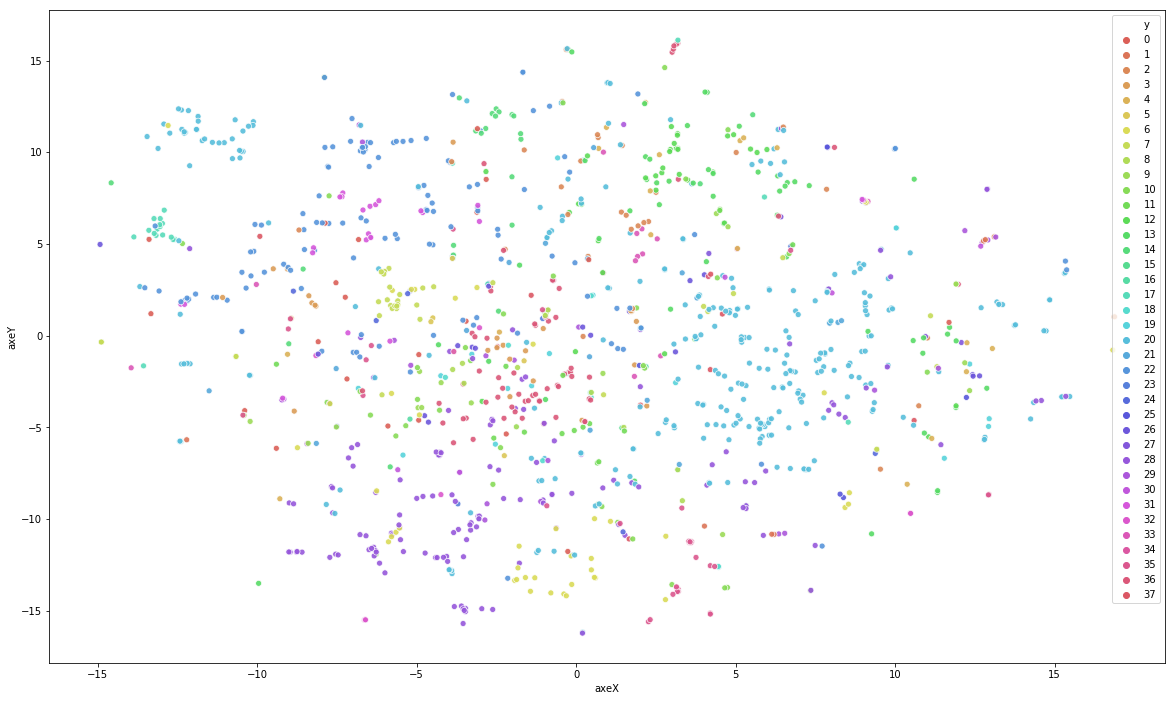

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt

df_tsne = pd.DataFrame()

df_tsne['y'] = true
df_tsne['axeX'] = tsne_data[:,0]
df_tsne['axeY'] = tsne_data[:,1]

plt.figure(figsize=(20,12))
sns.scatterplot(
    x="axeX", y="axeY",
    hue="y",
    palette=sns.color_palette("hls", 38),
    data=df_tsne,
    legend="full",
    alpha=0.9
)